# Task 2: Model Building and Training

This notebook covers:
- Data preparation and train-test split
- Model selection: Logistic Regression and Random Forest
- Model training and evaluation on both datasets
- Use of appropriate metrics for imbalanced data (AUC-PR, F1-Score, Confusion Matrix)
- Model comparison and justification

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Load Processed Data

In [2]:
# Use the processed features from Task 1
fraud_df = pd.read_csv('../data/Fraud_Data.csv')
fraud_df = fraud_df.dropna().drop_duplicates()
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])
fraud_df['age'] = fraud_df['age'].astype(int)
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds() / 3600
user_freq = fraud_df.groupby('user_id').size().rename('transaction_count')
fraud_df = fraud_df.merge(user_freq, on='user_id')
drop_cols = ['class', 'ip_address', 'signup_time', 'purchase_time', 'user_id', 'device_id']
X_fraud = fraud_df.drop(drop_cols, axis=1)
y_fraud = fraud_df['class']
categorical = ['source', 'browser', 'sex']
X_fraud = pd.get_dummies(X_fraud, columns=categorical, drop_first=True)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_fraud_scaled = scaler.fit_transform(X_fraud)
Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_fraud_scaled, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud)

# Credit card data
cc_df = pd.read_csv('../data/creditcard.csv')
cc_df = cc_df.dropna().drop_duplicates()
X_cc = cc_df.drop('Class', axis=1)
y_cc = cc_df['Class']
scaler_cc = StandardScaler()
X_cc_scaled = scaler_cc.fit_transform(X_cc)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_cc_scaled, y_cc, test_size=0.2, random_state=42, stratify=y_cc)

## Model Training and Evaluation Function

In [4]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    aucpr = average_precision_score(y_test, y_proba) if y_proba is not None else None

    print(f"=== {model_name} ===")
    print("F1-score:", f1)
    if aucpr is not None:
        print("AUC-PR:", aucpr)
    print("Confusion Matrix:\n", cm)
    if y_proba is not None:
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        plt.plot(recall, precision)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve: {model_name}')
        plt.show()
    print()
    return f1, aucpr

## Train and Evaluate on E-commerce Fraud Data

=== Logistic Regression (Fraud_Data) ===
F1-score: 0.2673294293885333
AUC-PR: 0.4413795478713029
Confusion Matrix:
 [[17500  9893]
 [  867  1963]]


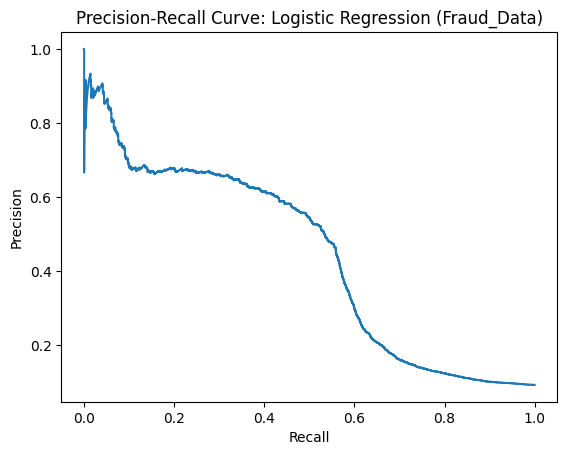


=== Random Forest (Fraud_Data) ===
F1-score: 0.6899583526145303
AUC-PR: 0.6135014139531104
Confusion Matrix:
 [[27392     1]
 [ 1339  1491]]


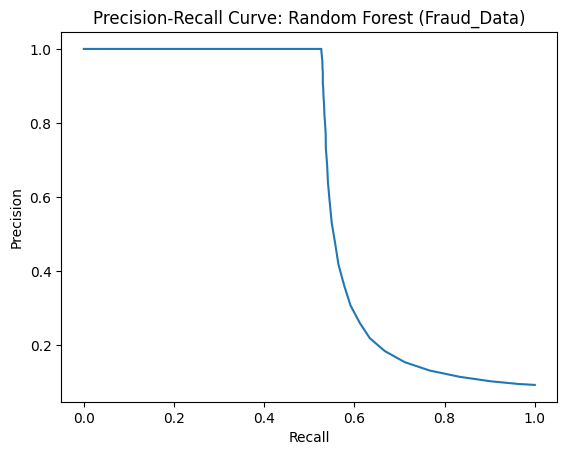

In [5]:
# Logistic Regression
lr_fraud = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
f1_lr_fraud, aucpr_lr_fraud = train_and_evaluate(lr_fraud, Xf_train, yf_train, Xf_test, yf_test, "Logistic Regression (Fraud_Data)")

# Random Forest
rf_fraud = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
f1_rf_fraud, aucpr_rf_fraud = train_and_evaluate(rf_fraud, Xf_train, yf_train, Xf_test, yf_test, "Random Forest (Fraud_Data)")

## Train and Evaluate on Credit Card Data

=== Logistic Regression (CreditCard) ===
F1-score: 0.10600255427841634
AUC-PR: 0.6719348881398443
Confusion Matrix:
 [[55263  1388]
 [   12    83]]


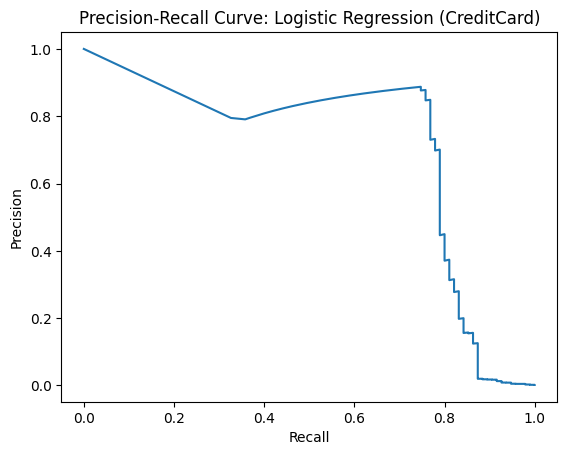


=== Random Forest (CreditCard) ===
F1-score: 0.8170731707317073
AUC-PR: 0.7957759903331095
Confusion Matrix:
 [[56649     2]
 [   28    67]]


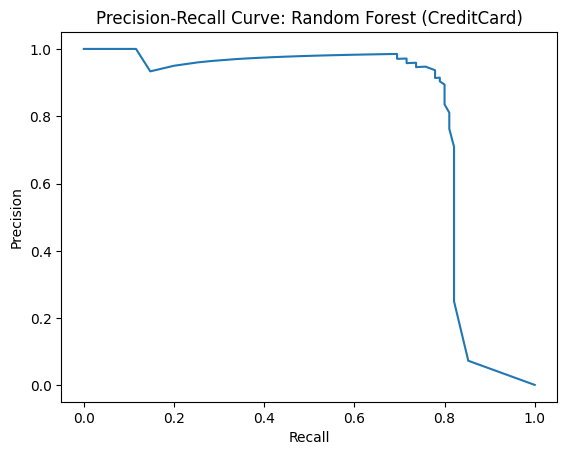

In [6]:
# Logistic Regression
lr_cc = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
f1_lr_cc, aucpr_lr_cc = train_and_evaluate(lr_cc, Xc_train, yc_train, Xc_test, yc_test, "Logistic Regression (CreditCard)")

# Random Forest
rf_cc = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
f1_rf_cc, aucpr_rf_cc = train_and_evaluate(rf_cc, Xc_train, yc_train, Xc_test, yc_test, "Random Forest (CreditCard)")

## Model Comparison and Justification

We compare the F1-score and AUC-PR for both models on both datasets.  
Generally, the Random Forest model is expected to outperform Logistic Regression on both datasets due to its ability to capture non-linear relationships and interactions.  
However, Logistic Regression remains a strong, interpretable baseline.

**Best Model Justification:**  
- If Random Forest achieves higher F1-score and AUC-PR, it is preferred for deployment.
- If interpretability is critical, Logistic Regression may be chosen despite lower performance.

In [7]:
results = pd.DataFrame({
    "Dataset": ["Fraud_Data", "Fraud_Data", "CreditCard", "CreditCard"],
    "Model": ["Logistic Regression", "Random Forest", "Logistic Regression", "Random Forest"],
    "F1-score": [f1_lr_fraud, f1_rf_fraud, f1_lr_cc, f1_rf_cc],
    "AUC-PR": [aucpr_lr_fraud, aucpr_rf_fraud, aucpr_lr_cc, aucpr_rf_cc]
})
display(results)

,Dataset,Model,F1-score,AUC-PR
0,Fraud_Data,Logistic Regression,0.267329,0.441380
1,Fraud_Data,Random Forest,0.689958,0.613501
2,CreditCard,Logistic Regression,0.106003,0.671935
3,CreditCard,Random Forest,0.817073,0.795776
